# Model Generation for GBIF Fungi Dataset

In [1]:
notebook_version = "0.0.1"
runs_dir = '/media/data/runs'
runs_hdf = 'runs.h5'

## References
* [Transfer Learning with Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
* [`tf.data`: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data?hl=en)

---

## Setup

In [2]:
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_hub as hub
from keras.utils.layer_utils import count_params

from sklearn.model_selection import train_test_split
import json

AUTOTUNE = tf.data.AUTOTUNE

### Limit GPU memory allocation
[Limiting GPU Memory Growth](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth)

In [3]:
def limit_memory_growth(limit=True):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, limit)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [4]:
limit_memory_growth()

1 Physical GPUs, 1 Logical GPUs


---

## Run Identifier

In [5]:
# ToDo: generate run_id from hdf runs.hdf in runs_dir
run_id = 0

In [6]:
# This run's path
run_path = os.path.join( runs_dir, str(run_id) )
run_path

'/media/data/runs/0'

In [7]:
if (os.path.exists( run_path )):
    print("Run path already exists!!")
    print(" Overwriting: %s" % run_path)
else:
    os.makedirs( run_path )

Run path already exists!!
 Overwriting: /media/data/runs/0


In [8]:
batch_size = 64

In [9]:
classifier_dropout = 0.33

---

## Define Model Base

In [10]:
# Array of tuples describing the models to be tested
# in the form: (model_handle, input_image_size, preprocessing_function)
# where the model_handle is a model building function or a url to a tfhub feature model
base_models = [
    {
        'source': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
        'input_dim': 224,
        # https://www.tensorflow.org/hub/common_signatures/images#input
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        'preprocessor': tf.keras.applications.mobilenet_v2.preprocess_input,
    },
    {
        'source': 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4',
        'input_dim': 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        'preprocessor': tf.keras.applications.inception_v3.preprocess_input,
    },
    {
        'source': 'https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5',
        'input_dim': 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        'preprocessor': tf.keras.applications.inception_v3.preprocess_input,
    },
    {
        'source': tf.keras.applications.Xception,
        'input_dim': 299,
        # The inputs pixel values are scaled between -1 and 1, sample-wise.
        'preprocessor': tf.keras.applications.xception.preprocess_input,
    },
    {
        'source': tf.keras.applications.resnet.ResNet101,
        'input_dim': 224,
        'preprocessor': tf.keras.applications.resnet50.preprocess_input,
    },
    {
        'source': tf.keras.applications.ResNet50,
        'input_dim': 224,
        'preprocessor': tf.keras.applications.resnet50.preprocess_input,
    },
    {
        'source': tf.keras.applications.InceptionResNetV2,
        'input_dim': 299,
        'preprocessor': tf.keras.applications.inception_resnet_v2.preprocess_input,
    },
    {
        'source': tf.keras.applications.efficientnet_v2.EfficientNetV2B0,
        'input_dim': 224,
        # The preprocessing logic has been included in the EfficientNetV2
        # model implementation. Users are no longer required to call this
        # method to normalize the input data. This method does nothing and
        # only kept as a placeholder to align the API surface between old
        # and new version of model.
        'preprocessor': tf.keras.applications.efficientnet_v2.preprocess_input,
    },
]

In [11]:
model = {}
model["base"] = base_models[2]

---

## Define Dataset

In [12]:
ds_hdf_path = '/media/data/gbif/clean_data.h5'
ds_hdf_key = 'media_merged_filtered-by-species_350pt'

ds_col_filename = 'filename'
ds_col_label = 'acceptedScientificName'

In [13]:
# Read in source dataframe
ds_df = pd.read_hdf( ds_hdf_path, ds_hdf_key )

### Dataset Information

In [14]:
ds_classes = ds_df[ ds_col_label ].unique()
print('Label count: %d' % len(ds_classes))
print('Datapoint count: %d' % len(ds_df))

Label count: 2451
Datapoint count: 665803


In [15]:
ds_df_label_vc = ds_df[ ds_col_label ].value_counts()
ds_df_label_vc = ds_df_label_vc.sort_values( ascending=False )

In [16]:
ds_df_label_vc.head()

Amanita muscaria (L.) Lam.              1050
Pisolithus arhizus (Scop.) Rauschert    1050
Phellinus igniarius (L.) Quél.          1030
Inonotus obliquus (Fr.) Pilát            968
Collybiopsis (J.Schröt.) Earle, 1909     942
Name: acceptedScientificName, dtype: int64

In [17]:
ds_df_label_vc.tail()

Cheimonophyllum candidissimum (Berk. & M.A.Curtis) Singer                                    101
Urocystis anemones (Pers.) G.Winter                                                          101
Melanelixia subargentifera (Nyl.) O.Blanco, A.Crespo, Divakar, Essl., D.Hawksw. & Lumbsch    101
Furia ithacensis (J.P.Kramer) Humber                                                         101
Fistulina antarctica Speg.                                                                   101
Name: acceptedScientificName, dtype: int64

<Axes: >

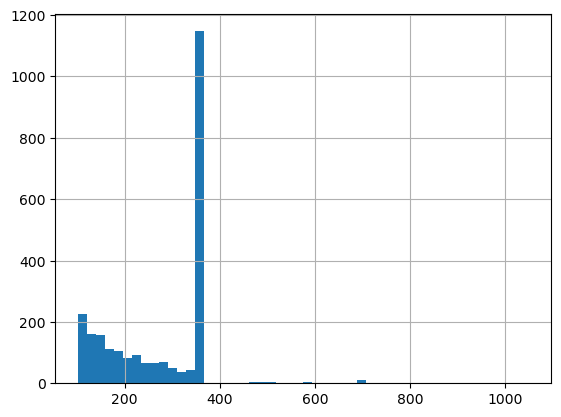

In [18]:
ds_df_label_vc.hist( bins=50 )

Most classes have 350 datapoints because I thought I had downsampled the datasets with more than 350 datapoints down to 350 but it looks like there are some that were not affected by the transformation I performed. There are some classes with more than 350 datapoints somehow. Regardless, we will be downsampling them all to the lowest value_count (101)...

### Dataset Transformation
(downsample, upsample, etc.)

In [19]:
# Downsample to equal number of samples per class
ds_df_label_vc_min = ds_df_label_vc.min()
print('Least number of samples per class: %d' % ds_df_label_vc_min)

Least number of samples per class: 101


In [20]:
ds_df_trans = ds_df.groupby( by=ds_col_label ).sample(n = ds_df_label_vc_min)
ds_df_trans[ds_col_label].value_counts()

Abortiporus biennis (Bull.) Singer                        101
Perenniporia fraxinea (Bull.) Ryvarden                    101
Peltula euploca (Ach.) Poelt ex Pišút                     101
Penicillium digitatum (Pers.) Sacc.                       101
Penicillium vulpinum (Cooke & Massee) Seifert & Samson    101
                                                         ... 
Ganoderma curtisii (Berk.) Murrill                        101
Ganoderma lobatum (Cooke) G.F.Atk.                        101
Ganoderma lucidum (Curtis) P.Karst.                       101
Ganoderma oregonense Murrill                              101
Yarrumia coronata (Müll.Arg.) D.J.Galloway                101
Name: acceptedScientificName, Length: 2451, dtype: int64

In [21]:
ds_df_trans[ds_col_label].value_counts().value_counts()

101    2451
Name: acceptedScientificName, dtype: int64

We have transformed the original dataset through downsampling to produce a dataset where all classes have the same number of datapoints as the class with the least amount of datapoints.

### Train, Validation, Test Split

In [ ]:
ds_split_test = 0.05
ds_split_val = 0.1

In [ ]:
ds_df_train, ds_df_test = train_test_split(
    ds_df_trans,
    test_size = ds_split_test,
    stratify = ds_df_trans[[ ds_col_label ]],
)

ds_df_train, ds_df_val = train_test_split(
    ds_df_train,
    test_size = ds_split_val,
    stratify = ds_df_train[[ ds_col_label ]],
)

### Input Data Pipeline Generation

In [ ]:
def load_image(
    filename,
):
    img_raw = tf.io.read_file( filename )
    img_tensor = tf.image.decode_image(
        img_raw,
        dtype = tf.dtypes.float32,
        channels = 3,
        expand_animations = False,
    )
    return img_tensor

In [ ]:
def resize(
    img_tensor,
    input_dim,
):
    return tf.image.resize(
        img_tensor,
        [ input_dim, input_dim ],
    )

In [ ]:
def preprocessing(
    img_tensor,
    preprocessor,
):
    return preprocessor( img_tensor )

In [ ]:
# Determines if preprocessing should be done in the IDP or in the model
preprocessing_in_ds = False

In [ ]:
def encode_label(
    label,
    classes,
):
    one_hot = label == classes
    label_encoded = tf.argmax( one_hot )
    return label_encoded

In [ ]:
def data_augmentation(
    img_tensor,
    augmentation_func,
):
    return augmentation_func(img_tensor, training = True)
    

In [ ]:
# Augmentation function selection
augmentation_functions = [
    tf.keras.Sequential( [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        
    ] )
]

# set augmentation_func to None if no augmentation is desired
augmentation_func = augmentation_functions[0]

# Determines if data augmentation should be done in the IDP or in the model
# Data augmentation will
data_augmentation_in_ds = True

In [ ]:
def make_idp(
    filenames,
    labels,
    input_dim,
    is_training = False,
    batch_size = 32,
    augmentation_func = None,
):
    ds = tf.data.Dataset.from_tensor_slices( (
        filenames,
        labels,
    ) )
    
    # image loading
    # (img_tensor, label)
    ds = ds.map(
        lambda filename, label: (
            load_image(filename),
            label,
        ),
        num_parallel_calls = AUTOTUNE,
    )

    # if isTraining, shuffle
    # use a buffersize equal to the length of the dataset
    if ( is_training ):
        # ds = ds.shuffle( buffer_size = len(filenames) )
        
        # if isTraining and augmentation_func exists, use data augmentation
        if ( augmentation_func ):
            ds = ds.map(
                lambda img_tensor, label: (
                    data_augmentation(img_tensor, augmentation_func),
                    label,
                ),
                num_parallel_calls = AUTOTUNE,
            )
    
    # image resizing
    # (img_tensor_resized, label)
    ds = ds.map(
        lambda img_tensor, label: (
            resize( img_tensor, input_dim ),
            label,
        ),
        num_parallel_calls = AUTOTUNE,
    )
    
    # image preprocessing
    # (img_tensor_resized_preprocessed, label)
    if ( preprocessing_in_ds ):
        ds = ds.map(
            lambda img_tensor_resized, label: (
                preprocessing(img_tensor_resized, model['base']['preprocessor']),
                label,
            ),
            num_parallel_calls = AUTOTUNE,
        )
    
    # label encoding
    # (img_tensor_resized_preprocessed, label_encoded)
    ds = ds.map(
        lambda img_tensor_resized_preprocessed, label: (
            img_tensor_resized_preprocessed,
            encode_label( label, ds_classes ),
        ),
        num_parallel_calls = AUTOTUNE,
    )
    
    # Batch
    ds = ds.batch( batch_size )
    
    # Prefetch
    ds = ds.prefetch( buffer_size = AUTOTUNE )
    
    return ds


In [ ]:
# IDP creation
ds_idp_train = make_idp(
    ds_df_train[ ds_col_filename ].values,
    ds_df_train[ ds_col_label ].values,
    input_dim = model['base']['input_dim'],
    is_training = True,
    batch_size = batch_size,
    augmentation_func = augmentation_func if ( augmentation_func and data_augmentation_in_ds ) else None,
)

ds_idp_val = make_idp(
    ds_df_val[ ds_col_filename ].values,
    ds_df_val[ ds_col_label ].values,
    input_dim = model['base']['input_dim'],
    is_training = False,
    batch_size = batch_size,
    # turned off by is_training = False anyway...
    augmentation_func = None,
)

ds_idp_test = make_idp(
    ds_df_test[ ds_col_filename ].values,
    ds_df_test[ ds_col_label ].values,
    input_dim = model['base']['input_dim'],
    is_training = False,
    batch_size = batch_size,
    # turned off by is_training = False anyway...
    augmentation_func = None,
)

In [ ]:
# def save_label_mapping(
#     label_mapping,
#     file_path = './label_mapping.json',
# ):
#     with open( file_path, 'w' ) as f:
#         json.dump( label_mapping, f, indent = 3 )

---

## Model Building

In [ ]:
# return a name that accurately describes the model building function or
# the tfhub model (by url) that was passed
def get_model_name( model_handle ):

    if callable(model_handle):
        return f'keras.applications/{model_handle.__name__}'
    else:
        split = model_handle.split('/')
        return f'tfhub/{split[-5]}.{split[-4]}.{split[-3]}'
    

In [ ]:
# Initialize full model
model["model"] = tf.keras.Sequential( name = "full_model" )

In [ ]:
# Input is assumed to be resized and preprocessed correctly from input dataset pipeline (idp)

In [ ]:
# generate base_model layer
def gen_base_model_layer(
    name,
    source,
    input_dim,
    trainable = False,
):
    # If model_handle is a model building function, use that function
    if callable( source ):
        base_model = source(
            include_top = False,
            input_shape = ( input_dim, input_dim ) + (3,),
            weights = 'imagenet',
            # pooling = 'avg',
        )

    # otherwise build a layer from the tfhub url that was passed as a string
    else:
        base_model = hub.KerasLayer(
            source,
            input_shape = ( input_dim, input_dim ) + (3,),
            name = name,
        )
    
    base_model.trainable = trainable

    return base_model


In [ ]:
# Add base model to full_model
model["model"].add( gen_base_model_layer(
    name = get_model_name( model['base']['source'] ),
    source = model['base']['source'],
    input_dim = model['base']['input_dim'],
    trainable = True,
) )

In [ ]:
# generate classifier
def gen_classifier_model_layer(
    num_classes,
    dropout,
):
    model = tf.keras.Sequential()
    model.add(
        layers.Dense(
            num_classes,
            # activation = 'softmax',
        )
    )

    model.add(
        layers.Dropout(dropout)
    )

    model.add(
        layers.Activation("softmax", dtype="float32")
    )

    return model

In [ ]:
# Add classifier model to full_model
# TODO allow selection between different classification models
model['model'].add( gen_classifier_model_layer(
    num_classes = len( ds_classes ),
    dropout = classifier_dropout,
) )

---

## Run Results Logging

In [ ]:
class RunLogging():

    hdf_key = "runs"

    def __init__(
        self,
        data_dir = "./",
        hdf_filename = "runs.h5",
    ):
        self.data_dir = data_dir
        self.filename =  os.path.join( data_dir, hdf_filename )
        self.df = self.load_metadata()

    def load_metadata(self):
        if ( os.path.exists(self.filename) ):
            return pd.read_hdf( self.filename, self.hdf_key )
        else: return pd.DataFrame()

    def save_df(self):
        self.df.to_hdf(self.filename, self.hdf_key)

    def add_run(self, params, log_dir, time, scores):

        cols = {
            **params,
            'time': time,
            'log_dir': log_dir,
            'scores.loss': scores[0],
            'scores.accuracy': scores[1],
            'scores.top3': scores[2],
            'scores.top10': scores[3],
        }

        new_run = pd.DataFrame([cols])

        self.df = pd.concat([self.df, new_run])
        self.save_df()

---

## Build and run all models

* Note regarding `thawed_base_model_layers` and full model architecture ([reference](https://stackoverflow.com/questions/64227483/what-is-the-right-way-to-gradually-unfreeze-layers-in-neural-network-while-learn))
![image](https://i.stack.imgur.com/JLJqv.png)
* [Another great reference](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)

# Training Run

In [ ]:
## Training
max_epochs = 20

### Optimizer
learning_rate = 0.0001

### Loss
label_smoothing = 0.1

# TODO: allow loading of model weights from previous run
load_weights = None

In [ ]:
# Run Logging
run_logs = RunLogging(
    data_dir = runs_dir,
)

base_model_id = get_model_name( model['base']['source'] )
run_log_dir = os.path.join( run_logs.data_dir, 'gbif', base_model_id )

In [ ]:
# Compile model
# Sparse vs non-sparse CCE https://www.kaggle.com/general/197993
model["model"].compile(
    optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate ),
    loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = False ),
    # loss = tf.keras.losses.CategoricalCrossentropy(
        # from_logits=True,
    #     label_smoothing = label_smoothing,
    # ),
    metrics = [
        'accuracy',
        # tf.keras.metrics.AUC(),
        tf.keras.metrics.SparseCategoricalCrossentropy(),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(
            k = 3,
            name="Top3",
        ),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(
            k = 10,
            name="Top10",
        ),
        # tf.keras.metrics.CategoricalCrossentropy(),            
        # tf.keras.metrics.TopKCategoricalAccuracy( k=3, name="Top3" ),
        # tf.keras.metrics.TopKCategoricalAccuracy( k=10, name="Top10" ),
    ],
)

In [ ]:
# Tensorboard logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = run_path,
    histogram_freq = 1,
)

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    # monitor='val_sparse_categorical_accuracy',
    monitor = 'val_loss',
    patience = 5,
    min_delta = 0.01,
)

# Model Checkpoints for saving best model weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(run_log_dir, 'best_model' ),
    save_best_only = True,
    monitor = 'val_loss',
    # mode = 'min', # should be chosen correctly based on monitor value
)


In [ ]:
# Train
history = model["model"].fit(
    ds_idp_train,
    validation_data = ds_idp_val,
    epochs = max_epochs,
    callbacks = [
        tensorboard_callback,
        early_stopping_callback,
        model_checkpoint_callback,
    ],
    # validation_freq=2,
)
